# The Largest MIDI Collection on the Internet
https://www.reddit.com/r/WeAreTheMusicMakers/comments/3ajwe4/the_largest_midi_collection_on_the_internet/  
  
130,000 Midi File Collection 3.65Gb Uncompressed / 1.02 Gb Compressed ZIP  

ジャンルは以下がある
- Pop
- Classical (Piano/Violin/Guitar)
- EDM
- VideoGame
- Movie/TV Theme

とりあえずPopに絞りたいが，どこに何があるのかよくわからない

In [1]:
import os, random, pickle, glob, numpy as np
from pathlib import Path
import pretty_midi
from pypianoroll import Multitrack, Track
from utils import grid_plot, Timer, pm_to_wave
from scipy.io import wavfile as spw
from pydub import AudioSegment as AS
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import multiprocessing
from multiprocessing import Pool

multiprocessing.cpu_count()

20

In [3]:
base_dir = "../datasets/largest_midi"
original_dir = os.path.join(base_dir, 'original')

アルファベットか数字のディレクトリ以外は少なくともPopではなさそうなので除外

In [4]:
all_midi_path = list(Path(original_dir).glob("[0-9A-Z]/**/*.[Mm][Ii][Dd]*"))
len(all_midi_path)

104553

さすがにこれだけでも相当ある

### サンプルを確認

In [16]:
sample_path = str(all_midi_path[-10])
print(sample_path)

../datasets/largest_midi/E/E/EarthFinalConflict.mid


In [17]:
ptm = pretty_midi.PrettyMIDI(sample_path)

ppr = Multitrack() # 拡張子がMidとかだと読み込めないのでpretty_midiをパースする
ppr.parse_pretty_midi(ptm)

In [ ]:
sample_wave_name = "./data/sample.wav"
audio = pm_to_wave(ptm, sample_wave_name)
Audio(sample_wave_name)

こんな感じの長いやつがいっぱいあるみたい  
しかしやはりどれがメロディなのかを発見するのは難しそう  
コードを取得するのも難しそう  
  
打楽器を分けてやるのはis_drumがあるから簡単  
と思ったが，program=119, is_drum=Falseみたいなのもあるので，プログラムナンバーで分けた方がよさそう

## melodyという名前のトラックがある曲を選ぶ

In [87]:
def has_instrument_named(instrument_name, ptm, perfect_match=False):
    for instrument in ptm.instruments:
        name = instrument.name
        name = name.lower()
        
        if perfect_match:
            if instrument_name == name:
                return True
        else:
            if instrument_name in name:
                return True
        
    return False

def extract_midi_with_melody_path(midi_path):
    try:
        ptm = pretty_midi.PrettyMIDI(str(midi_path))
    except:
        return None

    if has_instrument_named('melody', ptm):
        return str(midi_path).split(original_dir)[-1][1:]
    
    return None

# Test
test_path = os.path.join(original_dir, "E/E/Everlasting-Love.mid")
ptm = pretty_midi.PrettyMIDI(test_path)
print(has_instrument_named('melody', ptm))
print(extract_midi_with_melody_path(test_path))

True
E/E/Everlasting-Love.mid


In [70]:
midi_with_melody_list_path = os.path.join('./data', 'largest_midi', 'midi_with_melody_list.pkl')
multi_cpu_num = 10

In [62]:
p = Pool(multi_cpu_num)
midi_with_melody_list = p.map(extract_midi_with_melody_path, all_midi_path)
midi_with_melody_list = [path for path in midi_with_melody_list if path is not None]

print(len(midi_with_melody_list))
with open(midi_with_melody_list_path, 'wb') as f:
    pickle.dump(midi_with_melody_list, f)

/root/midi/.venv/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


10712


ふーんそこそこあんじゃん  
でも全体で10万もあるんだからもうちょっとほしいなぁ…

In [72]:
with open(midi_with_melody_list_path, 'rb') as f:
    midi_with_melody_list = pickle.load(f)

In [84]:
str(midi_with_melody_list[-3])

'../datasets/largest_midi/E/E/Everlasting-Love.mid'

In [83]:
ptm = pretty_midi.PrettyMIDI(str(midi_with_melody_list[-3]))
ptm.instruments

[Instrument(program=39, is_drum=False, name="SYN BASS 2"),
 Instrument(program=17, is_drum=False, name="ORGAN 2"),
 Instrument(program=59, is_drum=False, name="MELODY"),
 Instrument(program=90, is_drum=False, name="POLYSYNTH"),
 Instrument(program=48, is_drum=False, name="STRINGS"),
 Instrument(program=62, is_drum=False, name="SYNBRASS 1"),
 Instrument(program=52, is_drum=False, name="CHOIR AAHS"),
 Instrument(program=95, is_drum=False, name="SWEEP PAD"),
 Instrument(program=0, is_drum=True, name="DRUMS"),
 Instrument(program=1, is_drum=False, name="A.PIANO 2"),
 Instrument(program=39, is_drum=False, name="+SYNBASS 4"),
 Instrument(program=49, is_drum=False, name="SLOWSTRING"),
 Instrument(program=119, is_drum=False, name="REVERSCYMB")]

In [ ]:
sample_wave_name = "./data/sample.wav"
audio = pm_to_wave(ptm, sample_wave_name)
Audio(sample_wave_name)

## 単音楽器をメロディとする
ベースや打楽器類，また独特な楽譜になる楽器を除く単音楽器をメロディとする  
このとき，1小節の空白で区切ることにする．  
その上で，8小節を下回る長さの小節は扱わない  
一方，コード楽器は3和音以上をどこかで鳴らしている楽器に限定  
なお，二値化を前提とする

[GM1 Soundset](https://www.midi.org/specifications/item/gm-level-1-sound-set)の中で，メロディとしてもコードとしても扱わない楽器を明示  
なお，program_number = PC - 1なので注意

In [5]:
ignored_programs = set([
    8, 9, 10, 11, 12, 13, 14, 15, # Cromatic Perc
    31, # harmonics
    32, 33, 34, 35, 36, 37, 38, 39, 43, # Bass
    46, # Pizzicato
    47, # Timpani
    55, # Orchestra Hit
    58, # Tuba
    61, # Brass Section
    78, # Whistle
    87, # Bass + Lead
    96, 97, 98, 99, 100, 101, 102, 103, # FX
    104, 105, 106, 107, 108, 109, 110, 111, 112, 113, # Ethnic
    114, 115, 116, 117, 118, # Pitched Drums
    119, 120, 121, 122, 123, 124, 125, 126, 127 # SE
])

for i in ignored_programs:
    print(i, pretty_midi.program_to_instrument_name(i))

8 Celesta
9 Glockenspiel
10 Music Box
11 Vibraphone
12 Marimba
13 Xylophone
14 Tubular Bells
15 Dulcimer
31 Guitar Harmonics
32 Acoustic Bass
33 Electric Bass (finger)
34 Electric Bass (pick)
35 Fretless Bass
36 Slap Bass 1
37 Slap Bass 2
38 Synth Bass 1
39 Synth Bass 2
43 Contrabass
46 Orchestral Harp
47 Timpani
55 Orchestra Hit
58 Tuba
61 Brass Section
78 Whistle
87 Lead 8 (bass + lead)
96 FX 1 (rain)
97 FX 2 (soundtrack)
98 FX 3 (crystal)
99 FX 4 (atmosphere)
100 FX 5 (brightness)
101 FX 6 (goblins)
102 FX 7 (echoes)
103 FX 8 (sci-fi)
104 Sitar
105 Banjo
106 Shamisen
107 Koto
108 Kalimba
109 Bagpipe
110 Fiddle
111 Shanai
112 Tinkle Bell
113 Agogo
114 Steel Drums
115 Woodblock
116 Taiko Drum
117 Melodic Tom
118 Synth Drum
119 Reverse Cymbal
120 Guitar Fret Noise
121 Breath Noise
122 Seashore
123 Bird Tweet
124 Telephone Ring
125 Helicopter
126 Applause
127 Gunshot


上記の条件で，複数のpprを取得する関数

In [6]:
def is_4_by_4(ptm):
    tsc = ptm.time_signature_changes
    if len(tsc) < 1:
        return False
    
    for ts in tsc:
        if ts.numerator != 4 or ts.denominator != 4:
            return False
        
    return True

def remove_ignored_programs(ptm, ignored_programs, ignore_drum=True):
    remained_instruments = []
    for instrument in ptm.instruments:
        if ignore_drum and instrument.is_drum:
            continue
        if instrument.program in ignored_programs:
            continue
        remained_instruments.append(instrument)
    ptm.instruments = remained_instruments
    return ptm

class DownBeatResolution:
    """
    全てのトラックのresolutionを下げるので注意
    """
    def __init__(self, resolution_to, resolution_from=None, fill_mode=False):
        self.res_to = resolution_to
        self.res_from = resolution_from
        self.fill_mode = fill_mode
        
        if self.res_from is not None and self.res_to >= self.res_from:
            raise ValueError(f"Resolution_to (given: {self.res_to}) must be smaller than resolution_from (given: {self.res_from}).")

    def down_resolution(self, nproll, step_width):
        result = nproll[::step_width]
        if not self.fill_mode:
            note_existence = nproll.astype(bool)
            for s in range(1, step_width):
                result *= note_existence[s::step_width]
        return result
    
    def __call__(self, ppr):
        if self.res_from is None:
            if self.res_to >= ppr.beat_resolution:
                raise ValueError(f"Target resolution ({self.res_to}) must be smaller than the original resolution ({ppr.beat_resolution})")
            step_width = ppr.beat_resolution // self.res_to
        else:
            step_width = self.res_from // self.res_to
            
        ppr.beat_resolution = self.res_to
        ppr.downbeat = ppr.downbeat[::step_width]
        
        for ppr_track in ppr.tracks:
            ppr_track.pianoroll = self.down_resolution(ppr_track.pianoroll, step_width)
                    
        return ppr
down_beat_resolution = DownBeatResolution(12)

def discriminate_mono_poly(ppr, mono_threshold=0.99, poly_threshold=0.9):
    mono, poly = [], []
    
    for track_number, track in enumerate(ppr.tracks):
        pianoroll = track.pianoroll
        
        simultaneous_pitches_nums = np.sum(pianoroll, axis=1)
        on_note_steps = np.sum(simultaneous_pitches_nums > 0)
        if on_note_steps <= 0: continue
            
        mono_rate = np.sum(simultaneous_pitches_nums == 1, dtype=float) / on_note_steps
        poly_rate = np.sum(simultaneous_pitches_nums >= 3, dtype=float) / on_note_steps
        
        if mono_rate >= mono_threshold:
            mono.append(track_number)
        elif poly_rate >= poly_threshold:
            poly.append(track_number)

    return mono, poly

def create_chord_track(ppr, targets, offset_octave=4):
    # コードパートをすべて一つに統合したピアノロールを作成
    chord_pianoroll = np.zeros_like(ppr.tracks[targets[0]].pianoroll, dtype=bool)
    for target in targets:
        chord_pianoroll += ppr.tracks[target].pianoroll
    
    # それを1オクターブに収める
    chord_steps, chord_pitches = np.where(chord_pianoroll)
    chord_pitches = chord_pitches % 12 + offset_octave * 12
    chord_pianoroll = np.zeros_like(chord_pianoroll, dtype=bool)
    chord_pianoroll[chord_steps, chord_pitches] = 1
    
    # 後ろに伸ばして空白ステップをなくす．
    # 頭の空白は最初に音がなるところを前に伸ばす
    on_note_steps = np.zeros(len(chord_pianoroll))
    on_note_steps[chord_steps] = 1
    last_step = chord_pianoroll[chord_steps[0]]
    for step, is_on_note in enumerate(on_note_steps):
        if is_on_note:
            last_step = chord_pianoroll[step]
        else:
            chord_pianoroll[step] = last_step.copy()
    
    # コードトラックを作って返す
    chord_track = Track(pianoroll=chord_pianoroll, name='chord')
    return chord_track
            
    
import warnings
warnings.filterwarnings('error')

def get_mono_poly_ppr(midi_path, ignored_programs, verbose=False):
    with warnings.catch_warnings(): # Warningを出すようなファイルはつかわない. ex. 34132
        try:
            ptm = pretty_midi.PrettyMIDI(midi_path)
        except RuntimeWarning as e:
            if verbose: print(e)
            return None
        except Exception as e:
            if verbose: print(e)
            return None
    if verbose: print('no error')
    
    if is_4_by_4(ptm) != True:
        return None
    if verbose: print('4 by 4')
    
    ptm = remove_ignored_programs(ptm, ignored_programs)
    if len(ptm.instruments) < 2:
        return None
    if verbose: print('at least 2 instruments')
    
    ptm.remove_invalid_notes()
    
    ppr = Multitrack()
    ppr.parse_pretty_midi(ptm)
    ppr.binarize()
    
    ppr = down_beat_resolution(ppr)
    
    mono, poly = discriminate_mono_poly(ppr)
    if verbose: print(f'mono: {mono}, poly: {poly}')
    if len(mono) < 1 or len(poly) < 1:
        return None
    if verbose: print('enough mono and poly')
    
    chord_track = create_chord_track(ppr, poly)
    ppr.tracks = [ppr.tracks[mono_id] for mono_id in mono]
    ppr.tracks.append(chord_track)
    ppr.name = midi_path.split('/')[-1].split('.')[0]
    
    return ppr

index: 51001
path: ../datasets/largest_midi/original/B/B/brandy-almost_doesnt_count.mid
no error
4 by 4
at least 2 instruments
mono: [7], poly: [3, 5]
enough mono and poly
0.179714
65.0


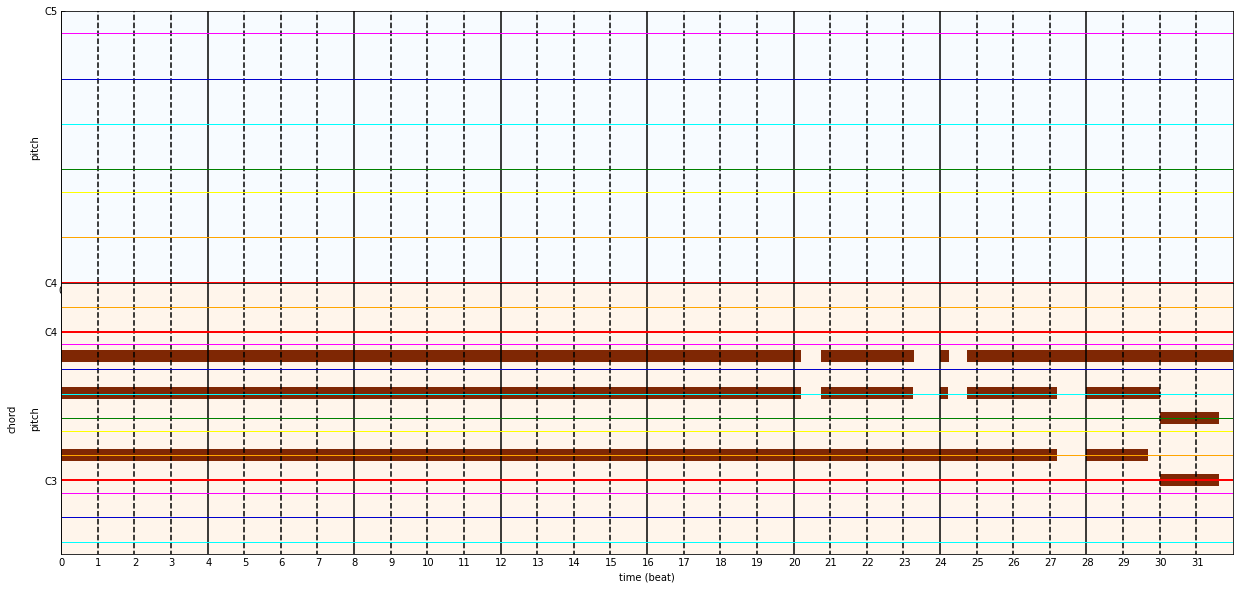

In [23]:
index = random.randint(0, len(all_midi_path)-1)
print(f"index: {index}")
sample_path = str(all_midi_path[index])
print(f"path: {sample_path}")
with Timer():
    ppr = get_mono_poly_ppr(sample_path, ignored_programs, verbose=True)

if ppr is not None:
    bar_res = ppr.beat_resolution * 4
    print(len(ppr.tracks[0].pianoroll) / bar_res)
    for track in ppr.tracks:
        track.pianoroll = track.pianoroll[bar_res*0:bar_res*8]
    grid_plot(ppr)

こういうのを求めてたんだよ  
../datasets/largest_midi/M/M/maoztzur.mid  


次の処理は実際の前処理に任せる
- 16小節に区切って何もない小節でsplit
    - 後で固定小節数を変更しても良いようにするため
- 最小小節数を下回るフレーズの削除
- メロディとコードの2パートからなるデータへの変換
- メタタグ用次元の追加

それでもなお質の良いデータとは言えなさそう…  
コードを完全に埋める方法がないため  
やっぱりMelodyの方がマシかな？  
あんまり数変わらなかったらMelodyにしよっと

### 並列処理と保存
加工済みデータを一度MIDIとして保存する  
本格的な前処理はモデルごとに行う

In [7]:
mono_poly_dir = os.path.join(base_dir, "mono_poly")

if not os.path.exists(mono_poly_dir):
    os.mkdir(mono_poly_dir)

head_dir_names = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for head_dir_name in head_dir_names:
    head_dir = os.path.join(mono_poly_dir, head_dir_name)
    if not os.path.exists(head_dir):
        os.mkdir(head_dir)

In [8]:
error_list = []
def process_mono_poly(midi_path):
    
    try:
        ppr = get_mono_poly_ppr(str(midi_path), ignored_programs)
    except Exception as e:
        error_list.append(midi_path)
        return None
    
    if ppr is None:
        return None
    
    name = ppr.name
    relative_path = os.path.join(name[0].upper(), f"{name}.mid")
    save_path = os.path.join(mono_poly_dir, relative_path)
    ppr.write(save_path)
    
    return relative_path

直列で動作テスト

In [9]:
mono_poly_list = []
with Timer():
    for midi_path in all_midi_path[:10]:
        relative_path = process_mono_poly(midi_path)
        if relative_path is not None:
            mono_poly_list.append(relative_path)

print(f"result: {len(mono_poly_list)} midi files saved")

2.809284
result: 2 midi files saved


In [ ]:
multi_cpu_num = 15
p = Pool(multi_cpu_num)
mono_poly_list = p.map(process_mono_poly, all_midi_path)
mono_poly_list = [path for path in mono_poly_list if path is not None]
print(f"result: {len(mono_poly_list)} midi files saved")

## Melodyが入った曲のみを抽出

In [16]:
def has_instrument_named(instrument_name, ptm, perfect_match=False):
    for instrument in ptm.instruments:
        name = instrument.name
        name = name.lower()
        
        if perfect_match:
            if instrument_name == name:
                return True
        else:
            if instrument_name in name:
                return True
        
    return False

def get_midi_with_melody_ppr(midi_path, ignored_programs, verbose=False):
    with warnings.catch_warnings(): # Warningを出すようなファイルはつかわない. ex. 34132
        try:
            ptm = pretty_midi.PrettyMIDI(midi_path)
        except RuntimeWarning as e:
            if verbose: print(e)
            return None
        except Exception as e:
            if verbose: print(e)
            return None
    if verbose: print('no error')
        
    if not has_instrument_named('melody', ptm):
        return None
    if verbose: print('melody part found')
    
    if is_4_by_4(ptm) != True:
        return None
    if verbose: print('4 by 4')
    
    ptm = remove_ignored_programs(ptm, ignored_programs)
    if len(ptm.instruments) < 2:
        return None
    if verbose: print('at least 2 instruments')
    
    ptm.remove_invalid_notes()
    
    ppr = Multitrack()
    ppr.parse_pretty_midi(ptm)
    ppr.binarize()
    
    ppr = down_beat_resolution(ppr)
    
    _, poly = discriminate_mono_poly(ppr)
    if verbose: print(f'poly: {poly}')
    if len(poly) < 1:
        return None
    if verbose: print('enough poly parts')
    
    chord_track = create_chord_track(ppr, poly)
    ppr.tracks = [track for track in ppr.tracks if 'melody' in track.name.lower()]
    ppr.tracks.append(chord_track)
    ppr.name = midi_path.split('/')[-1].split('.')[0]
    
    return ppr

In [17]:
with_melody_dir = os.path.join(base_dir, "with_melody")

if not os.path.exists(with_melody_dir):
    os.mkdir(with_melody_dir)

head_dir_names = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for head_dir_name in head_dir_names:
    head_dir = os.path.join(with_melody_dir, head_dir_name)
    if not os.path.exists(head_dir):
        os.mkdir(head_dir)

In [34]:
error_list = []
def process_midi_with_melody(midi_path):
    
    try:
        ppr = get_midi_with_melody_ppr(str(midi_path), ignored_programs)
    except Exception as e:
        error_list.append(midi_path)
        return None

    if ppr is None:
        return None
    
    name = ppr.name
    relative_path = os.path.join(name[0].upper(), f"{name}.mid")
    save_path = os.path.join(with_melody_dir, relative_path)
    ppr.write(save_path)
    
    return relative_path

直列で動作テスト

In [35]:
with_melody_list = []
with Timer():
    for midi_path in all_midi_path[:10]:
        relative_path = process_midi_with_melody(midi_path)
        if relative_path is not None:
            with_melody_list.append(relative_path)

print(f"result: {len(with_melody_list)} midi files saved")

2.477001
result: 0 midi files saved


In [ ]:
multi_cpu_num = 15
p = Pool(multi_cpu_num)
with_melody_list = p.map(process_midi_with_melody, all_midi_path)
with_melody_list = [path for path in with_melody_list if path is not None]
print(f"result: {len(with_melody_list)} midi files saved")